<a href="https://colab.research.google.com/github/dawmro/pytorch_tutorial/blob/main/Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Apr  2 22:09:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Initializations and Dataset Download

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dmrotek111@gmail.com
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


# 2. Imports

In [4]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import librosa # Library that is used to read and process audio files
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import time # Used to calculate time for each epoch or any processing time in seconds
from skimage.transform import resize # Used to resize the images and we will use it to resize audio waves

# detect the GPU if any, if not use CPU, change "cuda" to "mps" if you have a mac
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# 3. Data

In [5]:
data_df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv") # Read the original csv as a dataframe

data_df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset/' + data_df['FilePath'].str[1:] # Modify the paths in the dataframe


data_df.head() # Visualize the first 5 rows

,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


# 4. Data investigation

Data Shape is:  (6687, 2)


Claases Distrubution is: 


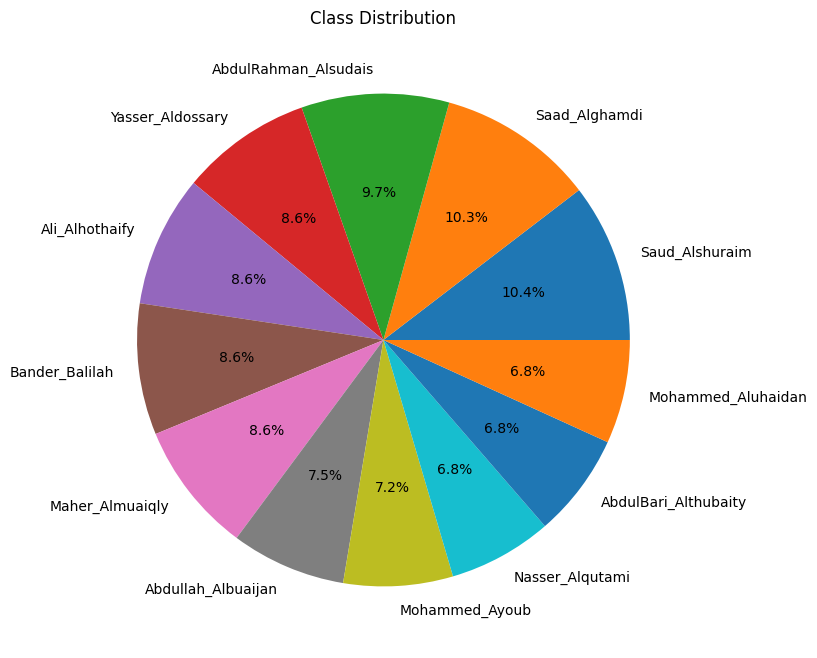

In [6]:
print("Data Shape is: ", data_df.shape) # Print the data shape (rows, columns)
print() # Empty line for better viewing

print() # Empty line for better viewing
print("Claases Distrubution is: ")

class_counts = data_df['Class'].value_counts() # Get how many data sample for each class
plt.figure(figsize=(8, 8)) # Plot a figure of 8 by 8 pixels

# we use this for plotting the how many data sample for each class
# autopct='%1.1f%%' automatically adds a label to each slice of
# the pie with its percentage of the whole, formatted to one decimal place.
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')


plt.title('Class Distribution') # Add title to the whole figure

plt.show() # Visualize/show the figure - Like print()

# 5. Data Split

In [7]:
label_encoder = LabelEncoder() # Defining our label encoder
data_df["Class"] = label_encoder.fit_transform(data_df["Class"]) # Class encoding

train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%


print("Training Shape: ", train.shape) # Print the Trainnig shape (rows, columns)
print("Validation Shape: ", val.shape) # Print the Validation shape (rows, columns)
print("Testing Shape: ", test.shape) # Print the Testing shape (rows, columns)

Training Shape:  (4681, 2)
Validation Shape:  (1003, 2)
Testing Shape:  (1003, 2)


# 6. Custom Dataset Class

In [8]:
class CustomAudioDataset(Dataset):
  """
  Custom dataset class for loading audio data.

  Args:
    dataframe (pd.DataFrame): Dataframe containing file paths and labels.
  """
  def __init__(self, dataframe):
    # Store the dataframe
    self.dataframe = dataframe
    # Convert labels to LongTensors and move to the device
    self.labels = torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)
    # Pre-compute spectrograms for all audio files and store them as FloatTensors
    self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

  def __len__(self):
    """
    Returns the total number of samples in the dataset.
    """
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    """
    Returns the audio spectrogram and label for a given index.

    Args:
      idx (int): Index of the sample to retrieve.

    Returns:
      tuple: (audio, label) where audio is a FloatTensor
             representing the spectrogram and label is a LongTensor.
    """
    # Get the image path from the dataframe
    img_path = self.dataframe.iloc[idx, 0]
    # Get the label and move it to the device
    label = torch.Tensor(self.labels[idx]).to(device)
    # Get the audio spectrogram, add a channel dimension, and move it to the device
    audio = (self.audios[idx]).unsqueeze(0).to(device)
    return audio, label

  def get_spectrogram(self, file_path):
    """
    Computes and returns the mel spectrogram of an audio file.

    Args:
      file_path (str): Path to the audio file.

    Returns:
      np.ndarray: Mel spectrogram of the audio file.
    """
    sr = 22050 # Set the sample rate of the audio file
    duration = 5 # Set the duration of the audio files

    # Set the size of the spectrogram images
    img_height = 128
    img_width = 256

    # Load the audio file
    signal, sr = librosa.load(file_path, sr=22050, duration=duration)

    # Compute the spectrogram
    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    # Convert the spectrogram to dB scale
    spec_db = librosa.power_to_db(spec, ref=np.max)

    # Resize the spectrogram to the desired shape
    spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
    return spec_resized

# 7. Create Dataset Objects

In [9]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

# 8. Hyperparameters

In [10]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

# 9. DataLoaders

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# 10. Model

In [12]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1) # First Convolution layer
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1) # Second Convolution layer
    self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1) # Third Convolution layer
    self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
    self.relu = nn.ReLU() # ReLU Activation function

    self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
    self.linear1 = nn.Linear((64 * 16 * 32), 4096) # Traditional Dense (Linear)
    self.linear2 = nn.Linear(4096, 1024) # Traditional Dense (Linear)
    self.linear4 = nn.Linear(1024, 512) # Traditional Dense (Linear)
    self.output = nn.Linear(512, len(data_df['Class'].unique())) # Output Linear Layer

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x) # -> Outputs: (16, (128, 256))
    x = self.pooling(x)# -> Outputs: (16, (64, 128))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv2(x) # -> Outputs: (32, (64, 128))
    x = self.pooling(x) # -> Outputs: (32, (32, 64))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv3(x) # -> Outputs: (64, (32, 64))
    x = self.pooling(x) # -> Outputs: (64, (16, 32))
    x = self.relu(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)


    x = self.linear4(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device


print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# 11. Model Summary

In [13]:
from torchsummary import summary # Visualize the model layers and number of parameters
summary(model, (1, 128, 256)) # Visualize the model layers by taking the input size expected (-1 in the output will be replaced by the batch size in training)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
           Dropout-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
         MaxPool2d-6           [-1, 32, 32, 64]               0
              ReLU-7           [-1, 32, 32, 64]               0
           Dropout-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
        MaxPool2d-10           [-1, 64, 16, 32]               0
             ReLU-11           [-1, 64, 16, 32]               0
          Dropout-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

# 12. Loss and Optimizer

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

# 13. Training

In [15]:
total_loss_train_plot = [] # Empty list to be filled with train loss after each epoch
total_loss_validation_plot = [] # Empty list to be filled with validation loss after each epoch
total_acc_train_plot = [] # Empty list to be filled with train accuracy after each epoch
total_acc_validation_plot = [] # Empty list to be filled with validation accuracy after each epoch


for epoch in range(EPOCHS):
  start_time = time.time() # We use this to calculate the time of each epoch, it starts a counter once called
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  epoch_string = f"""
                  Epoch: {epoch+1}/{EPOCHS},
                  Train Loss: {round(total_loss_train/100, 4)},
                  Train Accuracy: {round((total_acc_train/train_dataset.__len__() * 100), 4)},
                  Validation Loss: {round(total_loss_val/100, 4)},
                  Validation Accuracy: {round((total_acc_val/val_dataset.__len__() * 100), 4)}
                  """
  print(epoch_string)
  print("="*30)


                  Epoch: 1/25, 
                  Train Loss: 21.0667, 
                  Train Accuracy: 10.4465, 
                  Validation Loss: 1.5417, 
                  Validation Accuracy: 11.9641
                  

                  Epoch: 2/25, 
                  Train Loss: 7.1238, 
                  Train Accuracy: 11.8778, 
                  Validation Loss: 1.517, 
                  Validation Accuracy: 13.3599
                  

                  Epoch: 3/25, 
                  Train Loss: 6.9669, 
                  Train Accuracy: 14.7832, 
                  Validation Loss: 1.4505, 
                  Validation Accuracy: 18.5444
                  

                  Epoch: 4/25, 
                  Train Loss: 6.4995, 
                  Train Accuracy: 22.7302, 
                  Validation Loss: 1.31, 
                  Validation Accuracy: 27.318
                  

                  Epoch: 5/25, 
                  Train Loss: 5.5094, 
                  Train Acc

# 14. Testing

In [16]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 92.02%


# 15. Plotting Training Progress

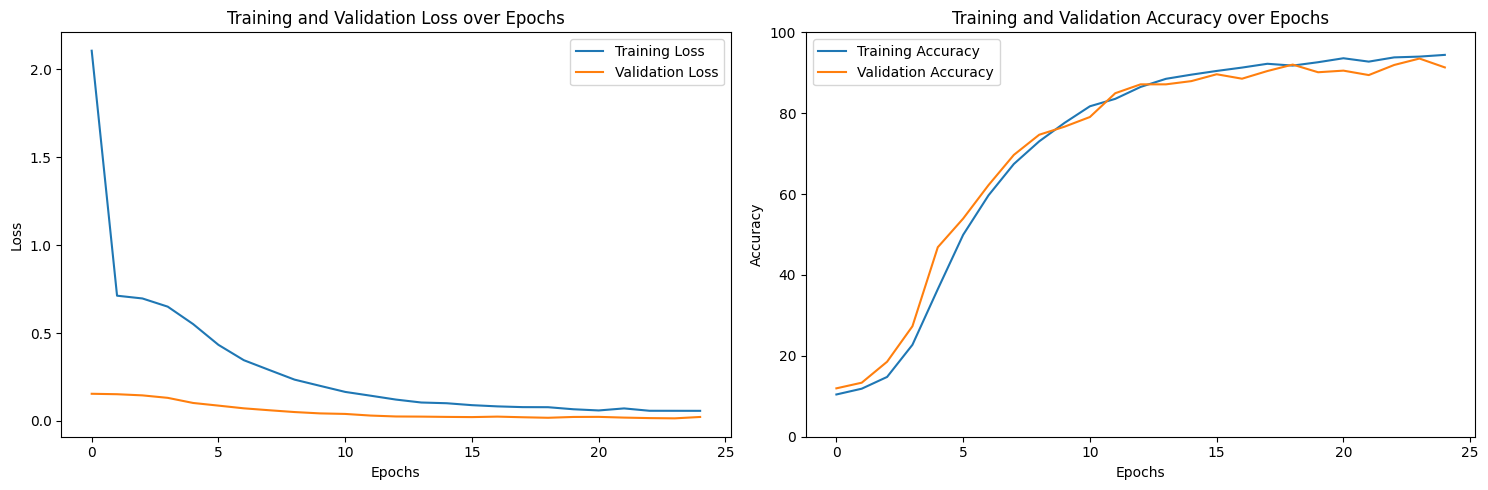

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()